In [72]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import librosa
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D


# ===== CONFIG =====
AUDIO_DIR = "E:/CS8321Final/CS8321FinalProject/out_of_tune_instruments/audio"
LABELS_CSV = "E:/CS8321Final/CS8321FinalProject/out_of_tune_instruments/labels.csv"
SAMPLE_RATE = 16000
DURATION_SEC = 4.0
N_MELS = 64
HOP_LENGTH = 256

# ===== MEL-SPECTROGRAM EXTRACTION =====
def extract_melspec(wav_path, n_mels=N_MELS, hop_length=HOP_LENGTH):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y = librosa.util.fix_length(y, size=int(SAMPLE_RATE * DURATION_SEC))
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return np.mean(S_db, axis=1)  # (n_mels,)

# ===== LOAD LABELS.CSV =====
df = pd.read_csv(LABELS_CSV)
df['filename'] = df['filename'].str.strip()
df['out_of_tune'] = df['out_of_tune'].astype(str).str.strip()

# ===== SELECT FIRST 50 .WAV FILES THAT EXIST IN LABELS =====
all_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')])
first_50_files = all_files[:50]

# Filter the DataFrame for those 50 files
df_filtered = df[df['filename'].isin(first_50_files)].reset_index(drop=True)

# Rebuild filepaths and labels
filepaths = [os.path.join(AUDIO_DIR, fname) for fname in df_filtered['filename']]
labels = df_filtered['out_of_tune'].values

# ===== DEBUG PRINTS (Optional) =====
print(f"✅ Total files selected: {len(filepaths)}")
print(f"✅ Labels matched: {len(labels)}")


✅ Total files selected: 50
✅ Labels matched: 50


In [73]:
# ===== ENCODE LABELS =====
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)
joblib.dump(label_encoder, 'label_encoder.joblib')

# ===== EXTRACT MEL FEATURES =====
X = np.stack([extract_melspec(fp) for fp in filepaths])  # Shape: (N, 64)
X = np.expand_dims(X, axis=-1)  # Shape: (N, 64, 1) → for CNN input
y = one_hot_labels

In [74]:
# ===== FILTER CLASSES WITH ≥5 SAMPLES =====
class_indices = np.argmax(y, axis=1)
(unique, counts) = np.unique(class_indices, return_counts=True)
valid_classes = unique[counts >= 5]
valid_indices = [i for i, cls in enumerate(class_indices) if cls in valid_classes]

X = X[valid_indices]
y = y[valid_indices]
class_indices = np.argmax(y, axis=1)

if len(X) == 0:
    raise ValueError("No valid samples left after filtering. Try reducing the min sample threshold.")

# ===== TRAIN TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=class_indices, test_size=0.2, random_state=42)

In [75]:
from tensorflow.keras import backend as K
K.clear_session()

# ===== 1D CNN MODEL FOR AUDIO FEATURES =====
input_layer = Input(shape=(64, 1))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,068 (238.55 KB)

 Trainable params: 61,068 (238.55 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# ===== CALLBACKS =====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# ===== EVALUATION =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ===== SAVE MODEL =====
model.save("fused_out_of_tune_model.h5")

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0000e+00 - loss: 6.9282WARNING:tensorflow:5 out of the last 65 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x0000019B5937DB20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 6.9282 - val_accuracy: 0.0000e+00 - val_loss: 3.3781 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1053 - loss: 7.1440 - val_accuracy: 0.0000e+00 - val_loss: 2.8672 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1053 - loss: 6.8985 - val_accuracy: 0.2000 - val_loss: 2.4368 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1053 - loss: 5.2338 - val_accuracy: 0.4000 - val_loss: 2.0954 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1053 - loss: 4.3571 - val_accuracy: 0.4000 - val_loss: 1.8261 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0000e+00 - loss: 5.2788 - val_accuracy: 0.4000 - val_loss: 1.6149 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1579 - loss: 4.5

c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


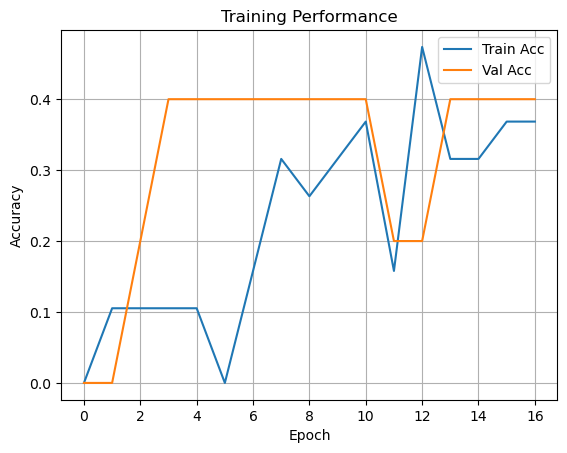

In [77]:
# ===== OPTIONAL: PLOT TRAINING =====
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Performance')
plt.grid()
plt.show()

# MLP Model

In [78]:
# ===== MLP MODEL FOR AUDIO FEATURES =====

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization


In [79]:
# Reshape input for MLP: (N, 64, 1) → (N, 64)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Clear previous session
K.clear_session()

mlp_model = Sequential()

In [80]:
# ===== INPUT LAYER =====
mlp_model.add(Input(shape=(64,)))

# ===== DEEP FULLY CONNECTED BLOCKS =====
mlp_model.add(Dense(1024, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.4))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))

# ===== OUTPUT LAYER =====
mlp_model.add(Dense(y.shape[1], activation='softmax'))

# ===== COMPILE =====
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,300 (2.92 MB)

 Trainable params: 760,716 (2.90 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [81]:
# ===== CALLBACKS =====
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN MLP MODEL =====
mlp_history = mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_test_mlp, y_test),
    epochs=30,
    batch_size=32,
    callbacks=mlp_callbacks
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1053 - loss: 3.4254 - val_accuracy: 0.0000e+00 - val_loss: 10.9869 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1579 - loss: 3.3127 - val_accuracy: 0.0000e+00 - val_loss: 9.7777 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1053 - loss: 2.6599 - val_accuracy: 0.0000e+00 - val_loss: 8.8474 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0526 - loss: 3.3751 - val_accuracy: 0.0000e+00 - val_loss: 8.1241 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1579 - loss: 2.5628 - val_accuracy: 0.0000e+00 - val_loss: 7.6025 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0526 - loss: 3.3050 - val_accuracy: 0.0000e+00 - val_loss: 7.1140 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy

In [82]:
# ===== EVALUATION =====
y_pred_probs_mlp = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_mlp = np.argmax(y_test, axis=1)

print("\nMLP Classification Report:\n", classification_report(y_true_mlp, y_pred_mlp))
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true_mlp, y_pred_mlp))

# ===== SAVE MLP MODEL =====
mlp_model.save("mlp_out_of_tune_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
          10       0.20      1.00      0.33         1

    accuracy                           0.20         5
   macro avg       0.07      0.33      0.11         5
weighted avg       0.04      0.20      0.07         5


MLP Confusion Matrix:
 [[0 0 2]
 [0 0 2]
 [0 0 1]]


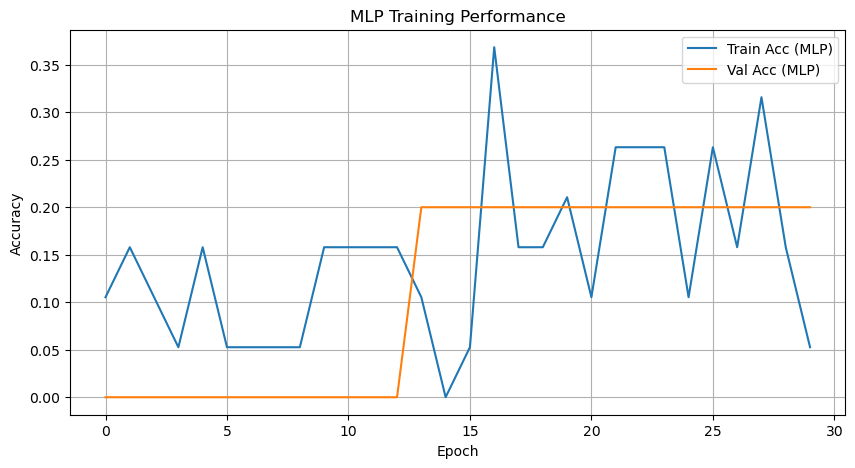

In [83]:
# ===== OPTIONAL: PLOT MLP TRAINING =====
plt.figure(figsize=(10,5))
plt.plot(mlp_history.history['accuracy'], label='Train Acc (MLP)')
plt.plot(mlp_history.history['val_accuracy'], label='Val Acc (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training Performance')
plt.grid()
plt.show()


# Transfer Learning

In [84]:
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [85]:
encoder = LabelEncoder()
encoded = encoder.fit_transform(labels)
y_all   = to_categorical(encoded)
counts  = np.bincount(np.argmax(y_all,axis=1))
valid_classes = np.where(counts>=5)[0]
valid_idx     = [i for i,c in enumerate(y_all) if np.argmax(c) in valid_classes]

filepaths = [filepaths[i] for i in valid_idx]
y_all     = y_all[valid_idx]

In [86]:
# ===== Load VGGish model from TensorFlow Hub =====
os.environ["TFHUB_CACHE_DIR"] = os.path.expanduser("~/my_project/tfhub_cache")
vggish = hub.KerasLayer(
    "https://tfhub.dev/google/vggish/1",
    input_shape=[SAMPLE_RATE * int(DURATION_SEC)],
    dtype=tf.float32,
    trainable=False,
    name="vggish"
)


In [87]:
def extract_emb(path):
    wav,_ = librosa.load(path, sr=SAMPLE_RATE, mono=True, duration=DURATION_SEC)
    target_len = int(SAMPLE_RATE * DURATION_SEC)
    if len(wav) < target_len:
        wav = np.pad(wav, (0, target_len-len(wav)), mode="constant")
    else:
        wav = wav[:target_len]
    patches = vggish(wav)                  # (T,128)
    return tf.reduce_mean(patches,axis=0).numpy().astype(np.float32)


In [88]:
X_vgg = np.stack([extract_emb(p) for p in filepaths], axis=0)  # (N,128)
y_vgg = y_all.astype(np.float32)

In [89]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_vgg, y_vgg,
    stratify=np.argmax(y_vgg,axis=1),
    test_size=0.2, random_state=42
)

# reshape for 1D-CNN
X_tr_c = X_tr[...,None]
X_te_c = X_te[...,None]


In [90]:
# ===== 1D CNN with VGGISH =====
def make_cnn1d_vgg(n_classes):
    inp = Input((128,1), dtype=tf.float32)
    x   = Conv1D(64,3,padding="same",activation="relu")(inp)
    x   = MaxPooling1D(2)(x)
    x   = Conv1D(128,3,padding="same",activation="relu")(x)
    x   = MaxPooling1D(2)(x)
    x   = GlobalAveragePooling1D()(x)
    x   = Dense(128,activation="relu")(x)
    x   = Dropout(0.3)(x)
    out = Dense(n_classes,activation="softmax")(x)
    m   = Model(inp,out)
    m.compile(optimizer=Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m

cnn_tl = make_cnn1d_vgg(y_tr.shape[1])
history_tl = cnn_tl.fit(
    X_tr_c, y_tr,
    validation_data=(X_te_c, y_te),
    epochs=20, batch_size=64,
    callbacks=[
      EarlyStopping("val_loss",5,restore_best_weights=True),
      ReduceLROnPlateau("val_loss",factor=0.2,patience=2,verbose=1)
    ]
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3158 - loss: 2.4327 - val_accuracy: 0.2000 - val_loss: 2.4483 - learning_rate: 1.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2632 - loss: 2.4317 - val_accuracy: 0.2000 - val_loss: 2.4435 - learning_rate: 1.0000e-04


In [92]:
#MLP on VGGish
def make_mlp_vgg(input_dim, n_classes):
    inp = Input((input_dim,), dtype=tf.float32)
    x   = Dense(256,activation="relu")(inp)
    x   = Dropout(0.5)(x)
    x   = Dense(128,activation="relu")(x)
    x   = Dropout(0.3)(x)
    out = Dense(n_classes,activation="softmax")(x)
    m   = Model(inp,out)
    m.compile(optimizer=Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m

mlp_tl = make_mlp_vgg(128, y_tr.shape[1])
hist_mlp_tl = mlp_tl.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=20, batch_size=64,
    callbacks=[
      EarlyStopping("val_loss",5,restore_best_weights=True),
      ReduceLROnPlateau("val_loss",factor=0.2,patience=2,verbose=1)
    ]
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.1053 - loss: 2.4272WARNING:tensorflow:5 out of the last 65 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x0000019B45F21EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1053 - loss: 2.4272 - val_accuracy: 0.2000 - val_loss: 2.2683 - learning_rate: 1.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0000e+00 - loss: 2.6165 - val_accuracy: 0.4000 - val_loss: 2.2517 - learning_rate: 1.0000e-04


In [93]:
#Evaluate Both Transfer Learning Models
def report_tl(model, X, y, title):
    y_pred = np.argmax(model.predict(X), axis=1)
    y_true = np.argmax(y, axis=1)
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xticks(rotation=45); plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

report_tl(mlp_tl, Xv_test,      yv_test, "MLP + VGGish (TL)")
report_tl(cnn_tl, Xv_te_c,      yv_test, "1D-CNN + VGGish (TL)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

=== MLP + VGGish (TL) ===


ValueError: Number of classes, 5, does not match size of target_names, 12. Try specifying the labels parameter

In [ ]:
#Plots
plt.figure(figsize=(10,4))
plt.plot(history.history['val_accuracy'],   'k--', label='CNN scratch')
plt.plot(mlp_history.history['val_accuracy'],'k:', label='MLP scratch')
plt.plot(hist_mlp_tl.history['val_accuracy'],'b-', label='MLP + VGGish')
plt.plot(hist_cnn_tl.history['val_accuracy'],'r-', label='CNN + VGGish')
plt.title("Val Accuracy: Scratch vs. Transfer-Learned")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()